In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
from pygadgetreader import readsnap
from astropy import units as u
from astropy import constants 

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


# to do:

1. Check units of Energies, leave everything in /GM
2. Eddington function.
3. Check dnu_dpsi of the hernquist profile agains the theoretical value.

In [62]:
halo_sph_pos = readsnap('./halos/LMC6_6.25M_vir_000', 'pos', 'dm')
halo_sph_vel = readsnap('./halos/LMC6_6.25M_vir_000', 'vel', 'dm')
halo_sph_pot = readsnap('./halos/LMC6_6.25M_vir_000', 'pot', 'dm')
halo_sph_ids = readsnap('./halos/LMC6_6.25M_vir_000', 'pid', 'dm')
halo_sph_mass = readsnap('./halos/LMC6_6.25M_vir_000', 'mass', 'dm')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Potential
Returning DM    Particle IDs
Returning DM    Mass


In [60]:
np.mean(halo_sph_pot)

-23138.848

(-100, 100)

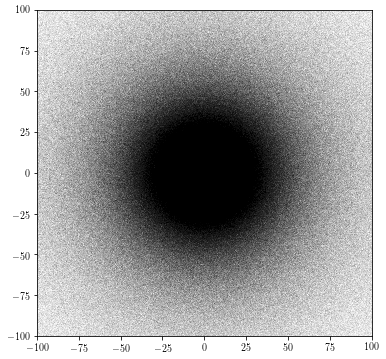

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(halo_sph_pos[:,0], halo_sph_pos[:,1], s=0.01, alpha=0.1, c='k')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

In [38]:
def truncate_halo(r, v, pot, E, pids):
    """
    Truncate halo.
    
    Input:
    ------
    
    
    Output:
    -------
    
    """
    
    r_cut = np.where((r<300) & (r>1))[0]
    
    return r[r_cut], v[r_cut], pot[r_cut], E[r_cut], pids[r_cut]

In [104]:
def relative_energies(r, Ep, Ek, m):
    """
    
    See B&T section 4.3 for the definitions.
    """
    
    G_c = constants.G
    print(G_c)
    G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
    print(G_c)
    # From N-body potential to kpc^2/s^2
    # in gadget G=43007.1 
    #print(G_c.value)
    pot_factor = G_c.value/43007.1 
    #G = 4.30071e-6
    
    phi = Ep*pot_factor*1E10 
    
    Psi=phi#-G_c.value*m*np.size(r)/np.max(r) #correction term (relative potential)
    E=Ek+Psi
    print(G_c.value*m*np.size(r)/np.max(r))

    shift_energy = -np.min(Psi) # Make the potential positive!
    E += shift_energy
    Psi += shift_energy
    
    return Psi, E

In [105]:
r_gal = (halo_sph_pos[:,0]**2 + halo_sph_pos[:,1]**2 + halo_sph_pos[:,2]**2)**0.5
v = (halo_sph_vel[:,0]**2 + halo_sph_vel[:,1]**2 + halo_sph_vel[:,2]**2)**0.5
v = v*u.km/u.s
v = v.to(u.kpc/u.s).value
v2 = v**2
Ek = 0.5 * v2


In [106]:
Psi, E = relative_energies(r_gal, halo_sph_pot, Ek, halo_sph_mass[0])

  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
4.517103050001135e-39 kpc3 / (s2 solMass)
2.23934684704e-42


In [68]:
r_gal_tr, Ek_tr, Psi_tr, E_tr, ids_tr = truncate_halo(r_gal, Ek, Psi, E, halo_sph_ids)

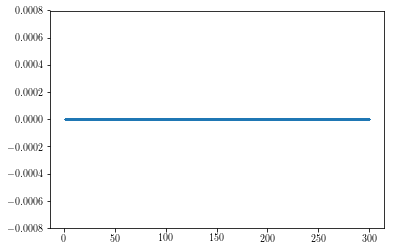

In [69]:
plt.scatter(r_gal_tr, Psi_tr, s=0.1)

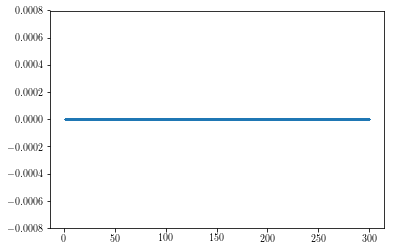

In [70]:
plt.scatter(r_gal_tr, Ek_tr, s=0.1)

In [71]:
def binning_data(r_gal, pot, Ek, E, bsize):
    """
    Binning the data in radial bins.
    
    Parameters:
    -----------
    
    Output:
    -------
    
    """
    
    r_gal_sort = r_gal[np.argsort(r_gal)]
    Ep_sort = pot[np.argsort(r_gal)]
    Ek = 0.5 * v2
    Ek_sort = Ek[np.argsort(r_gal)]
    E_sort = E[np.argsort(r_gal)]
    
    nbins = 300./bsize
    r_bins = np.linspace(0, 300, nbins)
    
    # Binning the energies!
    hist_radial_indexes = np.digitize(r_gal_sort, r_bins)
    r_gal_binned = [r_gal_sort[hist_radial_indexes == i].mean() for i in range(1, len(r_bins))]
    Ep_binned = [Ep_sort[hist_radial_indexes == i].mean() for i in range(1, len(r_bins))]
    Ek_binned = [Ek_sort[hist_radial_indexes == i].mean() for i in range(1, len(r_bins))]
    E_binned = [E_sort[hist_radial_indexes == i].mean() for i in range(1, len(r_bins))]
    
    return r_bins, Ep_binned, Ek_binned, E_binned

In [118]:
r_gal_bin, Psi_bin, Ek_bin, E_bin = binning_data(r_gal_tr, Psi_tr*1E28, Ek_tr, E_tr,  2)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


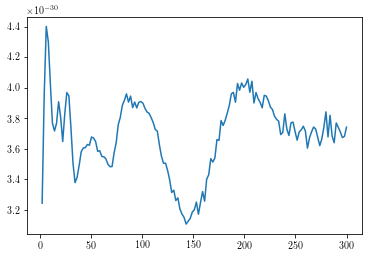

In [119]:
plt.plot(r_gal_bin[1:], Ek_bin)

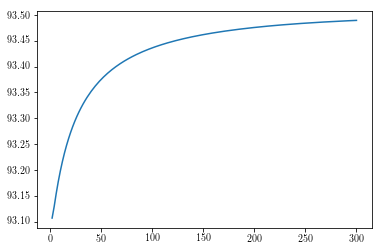

In [120]:
plt.plot(r_gal_bin[1:], Psi_bin)


In [121]:
def tracers_density(r_s, rbins, stellar_mass):
    """
    Input: 
    ------
    r_s : scale radius
    rbins : number of radial bins
    Returns:
    --------
    """
    #nu_tracer=(3.0/(4.0*np.pi*r_s**3))*(1.0+(rbins/r_s)**2)**(-2.5) # PLUMMER
    nu_tracer=(stellar_mass*r_s/(2.0*np.pi*rbins))/(r_s+rbins)**3 # HERNQUIST
    
    return nu_tracer

In [122]:
nu_tracers = tracers_density(20, r_gal_bin[:-1], 1e8)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


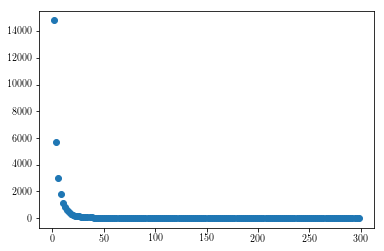

In [123]:
plt.scatter(r_gal_bin[:-1], nu_tracers)
#plt.ylim(-0.0001, 0.0001)

In [124]:
dnu_dpsi = np.gradient(nu_tracers, Psi_bin)
dnu_dpsi2 = np.gradient(dnu_dpsi, Psi_bin)

/usr/local/lib/python3.4/dist-packages/numpy/lib/function_base.py:1775: RuntimeWarning: invalid value encountered in add
  out[slice1] = a * f[slice2] + b * f[slice3] + c * f[slice4]
/usr/local/lib/python3.4/dist-packages/numpy/lib/function_base.py:1784: RuntimeWarning: invalid value encountered in subtract
  out[slice1] = (y[slice2] - y[slice3]) / dx_0


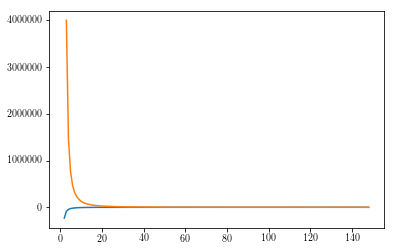

In [126]:
plt.plot(dnu_dpsi)
plt.plot(dnu_dpsi2)

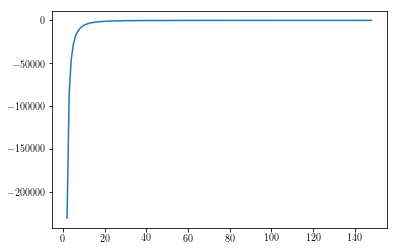

In [128]:
plt.plot(dnu_dpsi)

In [ ]:
def Eddington_formula(Psi, E, dn_dpsi, d2n_dpsi2):
    """
    B&T equation 4.46b
    
    """
    factor = 1 / (np.sqrt(8)*np.pi**2)
    
    
    
    for i in range(len(E)):
        dpsi = psi[i+1]-psi[i]
        term1 = dpsi * d2n_dpsi2[i]
        term2 = (1/np.sqrt(E[i]-psi[i])) * dnu_dpsi[i] 
        integrant[i] = term1 + term2
        
    f = factor * integrant

In [9]:
def weight_triaxial(r, Ek, Ep, a, partID, m, bsize, N_Eb, stellar_mass):
    
    r, Ep, Ek, stellar_mass = energies(r, Ep, Ek, stellar_mass)
    rbins, binsize_r, histo_rad, redges = binning_data(r, bsize)

    #TRACER PARAMETRISATION
    nu_tracer = tracers_density(r_s, rbins) 

    pot2 = binning_potential(histo_rad, redges)

    #Need to do the reverse indices here - 
    pot2-=shift_energy
    psi2=(-1.0)*pot2
    E-=shift_energy
    epsilon=(-1.0)*E 

    #Fetching derivatives from the data necessary for the Eddington formula evalution
    dnu_dpsi=np.gradient(psi2, nu_tracer)
    dnu2_dpsi2=np.gradient(psi2, dnu_dpsi)
    
    #Binning Energy for g(E) and f(E) (f(epsilon)) calculations                                
    
    Ebins = energy_bins(E)
    epsilon_bins = energy_bins(epsilon)
        
    #Total N(E) differential energy distribution
    Histo_M=Histo_E*m/np.sqrt((Ebins[2]-Ebins[1])**2) 
    
    """
    # EDDINGTON FORMULA --------------
    dpsi=np.ndarray(shape=np.size(psi2), dtype=float)
    for i in range (1, np.size(dpsi)):
        dpsi[i]=psi2[i]-psi2[i-1]
        
    distribution_function=np.ndarray(shape=np.size(epsilon_bins), dtype=float)
    
    for i in range(0,np.size(epsilon_bins)):
        w=np.where(psi2<epsilon_bins[i])
        #x=np.min(w) #i don't think I use this anywhere
        eps=epsilon_bins[i]
        if (np.size(w[0])!=0):
            w=np.array(w)
            tot1=dpsi[w[0,0]::]
            tot2=dnu2_dpsi2[w[0,0]::]
            tot3=np.sqrt(2.0*(eps-psi2[w[0,0]::]))
            tot=tot1*tot2/tot3
            val=(1.0)/(np.sqrt(8.0)*np.pi**2)*np.sum(tot) #Arthur's eval as Sum (in sims no divergence due to res)
            #print val, i, "val, i"
            distribution_function[i]=val
        else:
            distribution_function[i]=0
            
    #DENSITY OF STATES--------------
    wrme=np.ndarray(shape=np.size(Ebins), dtype=int)
    rme=np.ndarray(shape=np.size(Ebins), dtype=float)
    for i in range(0, np.size(Ebins)): 
        wpot_equals_E=np.where(pot2<=Ebins[i]) 
        if (np.size(wpot_equals_E)!=0):
            wrme[i]=np.max(np.array(wpot_equals_E))
        else:
            wrme[i]=0
            
    density_of_states=np.ndarray(shape=np.size(Ebins), dtype=float) # density of states integral (evaluated as sum)
    for i in range(0,np.size(Ebins)):
        if (np.size(wrme[i])==0):
            g1=0.0 
        else:
            g1=rbins[0:wrme[i]]**2
            g2=np.sqrt(2.0*(Ebins[i]-pot2[0:wrme[i]]))
            density_of_states[i]=(4.0*np.pi)**2*np.sum(binsize_r[0:wrme[i]]*g1*g2)
                                                              
    indsort=np.argsort(distribution_function) #sorted indices
    indsort=indsort[::-1] #reverse   
    # weights= D.F(tracers)/ (D.F.(self-consistent)) - self-consistent D.F. f(E) generates the potential Phi 
    # N(E)=f(E)*g(E)
    Weights=distribution_function[indsort[::-1]]/((Histo_M)/density_of_states) 

    # cast the weights to every particle
    Weights_array=np.ndarray(shape=np.size(r), dtype=float) 
    for j in range(0, np.size(Edges)-1):
        wbin=np.where((E>=Edges[j]) & (E<Edges[j+1]))
        if(np.size(wbin[0])!=0):
            Weights_array[wbin]=Weights[j] 
    
    #Ensure that the sum of the weights = mass of the tracers - this is not strictly needed
    X=stellar_mass/(np.sum(Weights_array)*m)
    Weights_array=Weights_array*X
    print(np.size(Weights_array))

    #return the IDS from which the weights are associated to the particles
    #needed for tracking where the tracers end up in subsequent snapshots
    return {'weights':Weights_array, 'ids':partID} 
    """